In [25]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, LeakyReLU, Flatten, ReLU, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
tf.test.is_gpu_available()

False

# REFERENCES
* Improved Techniques for Training GANs
* Improved Training of Wasserstein GANs
* UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS
* https://github.com/soumith/ganhacks
* https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

# THE PLAN 
    1) Dataset
        - MNIST dataset 
    2) Bulid Discriminator
        - 2 Convolutional Layer Model to indentify if the image is real or fake
    3) Bulid Generator
        - Input - 128 element vector with Gaussian random numbers
        - Output - grayscale image 28*28 pixels with values [0,1] 
    4) Evaluating GAN model
    5) Traning

# TIPS
* Batch size 8,16,64
* Noise dimension 128,256 instead of 100
* Wasserstein loss function
* Learning rates: Discriminator - 0.0004, Generator - 0.0001
* __SGD__ for Discriminator and __Adam__ for Generator

# DATASET

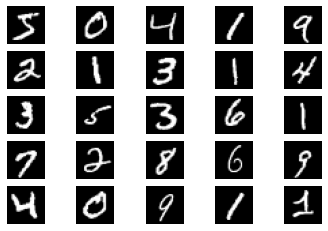

Image shape : (28, 28, 1), Size of the dataset: 30000


In [3]:
# Plot function
def plot(dataset): 
    for i in range(25):
        plt.subplot(5,5,i + 1)
        plt.axis('off')
        plt.imshow(dataset[i],cmap = 'gray')
    plt.show()
    
(x_train, _ ), (_ , _) = tf.keras.datasets.mnist.load_data()
plot(x_train)
x_train = np.expand_dims(x_train,axis = -1)
x_train = x_train.astype('float32') / 255
x_train = x_train[:30000]
print("Image shape : {}, Size of the dataset: {}".format(x_train[0].shape, x_train.shape[0]))

# DISCRIMINATOR

In [4]:
def Discriminator(img_shape = (28,28,1)):
    model = Sequential() 
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', input_shape = img_shape))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(lr=0.0002, beta_1 = 0.5)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

# GENERATOR

In [5]:
def Generator(latent_dim):
    model = Sequential() 
    
    n_nodes = 128*7*7
    model.add(Dense(n_nodes, input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.2))
    # model.add(BatchNormalization(momentum = 0.9))
    model.add(Reshape((7,7,128)))
    
    # Upsample 7x7 feature map to 14x14 
    model.add(Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.2))
    # model.add(BatchNormalization(momentum = 0.9))
    
    # Upsample 14x14 feature map to 28x28 image
    model.add(Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.2))
    # model.add(BatchNormalization(momentum = 0.9))
    model.add(Conv2D(filters = 1, kernel_size = (7,7), activation = "sigmoid", padding = 'same'))
    
    return model

# SAMPLES

In [6]:
def true_samples(dataset, no_sample):
    index = np.random.randint(0,dataset.shape[0],no_sample)
    
    images = dataset[index]
    
    labels = np.ones((no_sample,1))
    return images,labels

def fake_samples(generator, input_dim, no_sample):
    noise = np.random.randn(input_dim*no_sample).reshape(no_sample, input_dim)
    print(noise.shape)

    gen_images = generator.predict(noise)

    labels = np.zeros((no_sample,1))
    return gen_images,labels

# GAN

In [7]:
def GAN(generator, discriminator):
    discriminator.trainable = False
    
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
    
    model.compile(optimizer=optimizer, loss = 'binary_crossentropy')
    return model

# TRANING 

In [8]:
def save(model,epoch,s=6): 
    x_fake, _ = fake_samples(model,128,s*s)
    print(x_fake.shape)
    for i in range(s*s):
        plt.subplot(s,s,1+i)
        plt.axis('off')
        plt.imshow(x_fake[i])
    plt.savefig(r'GAN/epoch{}.png'.format(epoch))
    plt.close()

def summerize(g_loss, d_loss): 
    epoches = np.arange(len(g_loss))
    plt.plot(g_loss, epoches)
    plt.plot(d_loss, epoches)
    plt.legend(["g_loss", "d_loss"])
    plt.save(r"GAN/Performance.png")

In [9]:
def train(gan, generator, discriminator,dataset, epoches = 100, batch = 64, latent_dim = 128):
    half_batch = batch//2
    for i in range(epoches):
        for j in range(half_batch): 
            x_fake, y_fake = fake_samples(generator, latent_dim, half_batch)
            x_real, y_real = true_samples(dataset, half_batch)
            X,y = np.vstack((x_real,x_fake)), np.vstack((y_real,y_fake))
            _, d_loss = discriminator.train_on_batch(X,y)
            
            x_gan = np.random.randn(latent_dim*batch).reshape(batch, latent_dim)
            y_gan = np.ones((batch,1))
            g_loss = gan.train_on_batch(x_gan, y_gan)
            
        save(generator,str(i)+str(j))
        gan.save(r'GAN/model.{}.h5'.format(i))
    summerize(g_loss,d_loss)

In [ ]:
generator = Generator(128)
discriminator = Discriminator()
gan = GAN(generator, discriminator)
train(gan, generator, discriminator, x_train)

(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28,

(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28,

(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28, 28, 1)
(36, 28,